In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import sklearn as skl
import statsmodels.formula.api as smf
import sklearn.linear_model as lm

# Data from https://www.kaggle.com/neuromusic/avocado-prices
data = pd.read_csv('avocado.csv')
print(data.head(4))

   Unnamed: 0        Date  AveragePrice  ...          type  year  region
0           0  2015-12-27          1.33  ...  conventional  2015  Albany
1           1  2015-12-20          1.35  ...  conventional  2015  Albany
2           2  2015-12-13          0.93  ...  conventional  2015  Albany
3           3  2015-12-06          1.08  ...  conventional  2015  Albany

[4 rows x 14 columns]


#Crude Plots and Basic Data Intuition

Text(0, 0.5, 'Type')

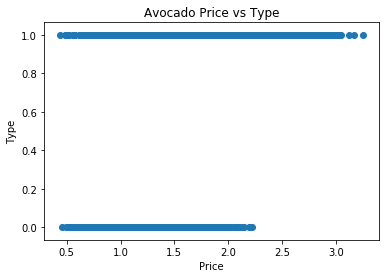

In [0]:
# Split data into organic and conventional (binary split)
price = data['AveragePrice']
organic = []
for i in data['type']:
  if i=='organic':
    organic.append(1)
  else:
    organic.append(0)

plt.scatter(price, organic)
plt.title("Avocado Price vs Type")
plt.xlabel("Price")
plt.ylabel("Type")

##Some more data exploration (not used in report)

In [0]:
# Split data by date 2 ways: by month and by general season (Summer, Fall, Winter, Spring)

dates = []

for i in data['Date']:
  dates.append(i.split('-'))
print(dates[0:5])

[['2015', '12', '27'], ['2015', '12', '20'], ['2015', '12', '13'], ['2015', '12', '06'], ['2015', '11', '29']]


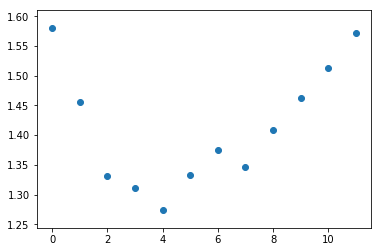

In [0]:
# Separate by month first and average by month (as we dont know if there are
# equal number of data points for each month)
month_price = np.zeros(12)
counts = np.zeros(12)
for i, n in enumerate(dates):
  month_price[int(n[1]) - 1] += price[i]
  counts[int(n[1]) - 1] += 1
month_price /= counts
# Shift the frame here a little so we can see the trend in the data
index = [9,10,11,0,1,2,3,4,5,6,7,8]
plt.scatter(range(12), month_price[index])
plt.xlabel("Month")
plt.ylabel("Averaged Price")
plt.plot("Avocado Price by Month")

# This clearly doesn't look linear, so we would have to do some non-linear regrassion
# or some type of data normalization (looks pretty parabolic)

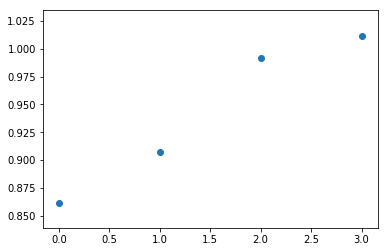

In [0]:
# Now categorize by season
season_price = np.zeros(4)
for i in range(4):
  season_price[i] = np.sum(month_price[3 * i:3 * i + 2]) / 3

plt.scatter(range(4), season_price)
plt.xlabel("Season")
plt.ylabel("Averaged Price")
plt.plot("Avocado Price by Season")
# Now this looks pretty linear, average price is higher in later seasons

#Data Analysis and Modeling

In [0]:
# We are going to create 2 a logistic model comparing price with avocado type.

# Create a training and test data set
train = data.sample(frac=0.8)
test = data.drop(train.index)


price_train = train['AveragePrice']
price_test = test['AveragePrice']
organic_train = []
organic_test = []

for i in train['type']:
  if i == 'organic':
    organic_train.append(1)
  else:
    organic_train.append(0)

for i in test['type']:
  if i == 'organic':
    organic_test.append(1)
  else:
    organic_test.append(0)


##Logictic Model for Organic or Conventional

In [0]:
price_train = np.asarray(price_train).reshape(-1, 1)
avofit = lm.LogisticRegression(solver='newton-cg').fit(price_train, organic_train)
print("Intercept (bias): ", float(avofit.intercept_), "\nCoefficient: ", float(avofit.coef_))

Intercept (bias):  -7.148041977741811 
Coefficient:  5.164820643368882


Text(0.5, 1.0, 'Avocado Price Based on Type')

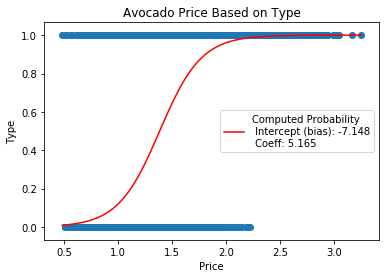

In [0]:
avo_x = np.linspace(np.asarray(price_train).min(), np.asarray(price_train).max(), len(price_train))
avo_y = avofit.predict_proba(avo_x.reshape(-1, 1))
plt.plot(avo_x, avo_y[:, 1] ,'r')
plt.scatter(price_train, organic_train)
plt.xlabel("Price")
plt.ylabel('Type')
plt.legend(["Computed Probability\n Intercept (bias): -7.148\n Coeff: 5.165"])
plt.title("Avocado Price Based on Type")

Accuracy:  79.53424657534246 %


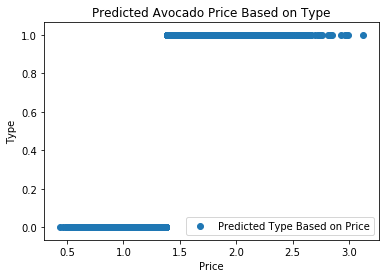

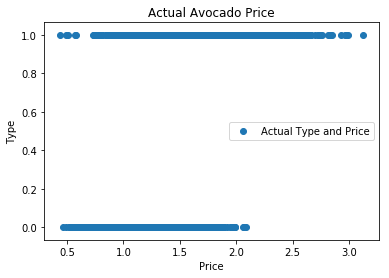

In [0]:
# Test model accuracy using the held out testing data

organic_predict = avofit.predict(np.asarray(price_test).reshape(-1, 1))
plt.scatter(price_test, organic_predict)
plt.legend(["Predicted Type Based on Price"])
plt.xlabel('Price')
plt.ylabel('Type')
plt.title('Predicted Avocado Price Based on Type')
plt.figure()
plt.scatter(price_test, organic_test)
plt.legend(["Actual Type and Price"])
plt.xlabel('Price')
plt.ylabel('Type')
plt.title('Actual Avocado Price')
accuracy = 0
for i in range(len(organic_test)):
  if organic_test[i] == organic_predict[i]:
    accuracy += 1
print("Accuracy: ", accuracy / len(price_test) * 100, "%")

In [0]:
print("Classification Report of the testing data:")
print(skl.metrics.classification_report(organic_test, organic_predict))
print("Classification Report of the training data:")
print(skl.metrics.classification_report(organic_train, avofit.predict(np.asarray(price_train).reshape(-1, 1))))
# Looks like the precision and recall are similar so we probably avoided overfitting. 

Classification Report of the testing data:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1814
           1       0.81      0.77      0.79      1836

    accuracy                           0.80      3650
   macro avg       0.80      0.80      0.80      3650
weighted avg       0.80      0.80      0.80      3650

Classification Report of the training data:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      7312
           1       0.81      0.79      0.80      7287

    accuracy                           0.80     14599
   macro avg       0.80      0.80      0.80     14599
weighted avg       0.80      0.80      0.80     14599

